# Speaker Veirification

This notebook illustrates the potential of `embeddings` by providing multiple ways to visualize them in the context of `Speaker Veirification (SV)` ! SV  aims to recognize a speaker based on an audio sample, and reference samples from different speakers (including the target one).

## Model + samples loading

In [3]:
from utils import *
from models import get_pretrained

model = get_pretrained('audio_encoder_256_mel_lstm_2')

print(model)


========== audio_encoder_256_mel_lstm_2 ==========
Model instance `model`
- Inputs 	: (None, None, 80)
- Outputs 	: (None, 256)
- Number of layers 	: 28
- Number of parameters 	: 2.669 Millions

- Optimizer 	: {'name': 'RMSprop', 'learning_rate': {'module': 'custom_train_objects.optimizers.lr_schedulers', 'class_name': 'DivideByStep', 'config': {'minval': 9.999999747378752e-06, 'maxval': 0.009999999776482582, 'factor': 1.0}, 'registered_name': 'DivideByStep'}, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
- Loss 	: {'name': 'ge2e_loss', 'reduction': 'sum_over_batch_size', 'mode': 'softmax', 'init_w': 9.926517486572266, 'init_b': 0.14750148355960846, 'distance_metric': 'euclidian'}

Already trained on 25 epochs (63201 steps)

- Embedd

In [4]:
from utils.datasets import get_dataset, train_test_split

samples = get_dataset('common_voice', subset = 'train')
samples = sample_df(samples, n = 25, n_sample = 50, min_sample = 50)

samples, new_samples = train_test_split(samples, valid_size = 0.5, labels = 'id', shuffle = True)
print('# samples : {} ({} ids)'.format(len(samples), len(samples['id'].unique())))
print('# samples : {} ({} ids)'.format(len(new_samples), len(new_samples['id'].unique())))

Loading dataset common_voice...
The dataset common_voice has no predefined subsets. The function will return the complete dataset
# samples : 625 (25 ids)
# samples : 625 (25 ids)


In [5]:
# This ensures that the 25 samples from each speaker are consecutive
# This will be more convenient for similarity matrix visualization ;)
samples.sort_values('id', inplace = True)
new_samples.sort_values('id', inplace = True)

In [10]:
embeddings = model.embed(samples)
print('Embeddings shape : {}'.format(embeddings.shape))#model.plot_embedding(sample_df(valid, n = 25, n_sample = 25))

Embeddings shape : (625, 256)


## Embeddings visualization

A first simple visualization is to project embeddings, which are *N*-dimensional vectors, into the 2D space, via a projection algorithm (default is `UMAP`, but `PCA` or `TSNE` can also be used). 

In the below plot, each circle corresponds to an audio sample, and each color corresponds to a different speaker. It can be observed that samples from a single speaker are grouped into well-separated clusters ! This well demonstrates the quality of the embeddings produced, as it is therefore possible to use clustering methods / distance-based classifiers to recognize speakers !

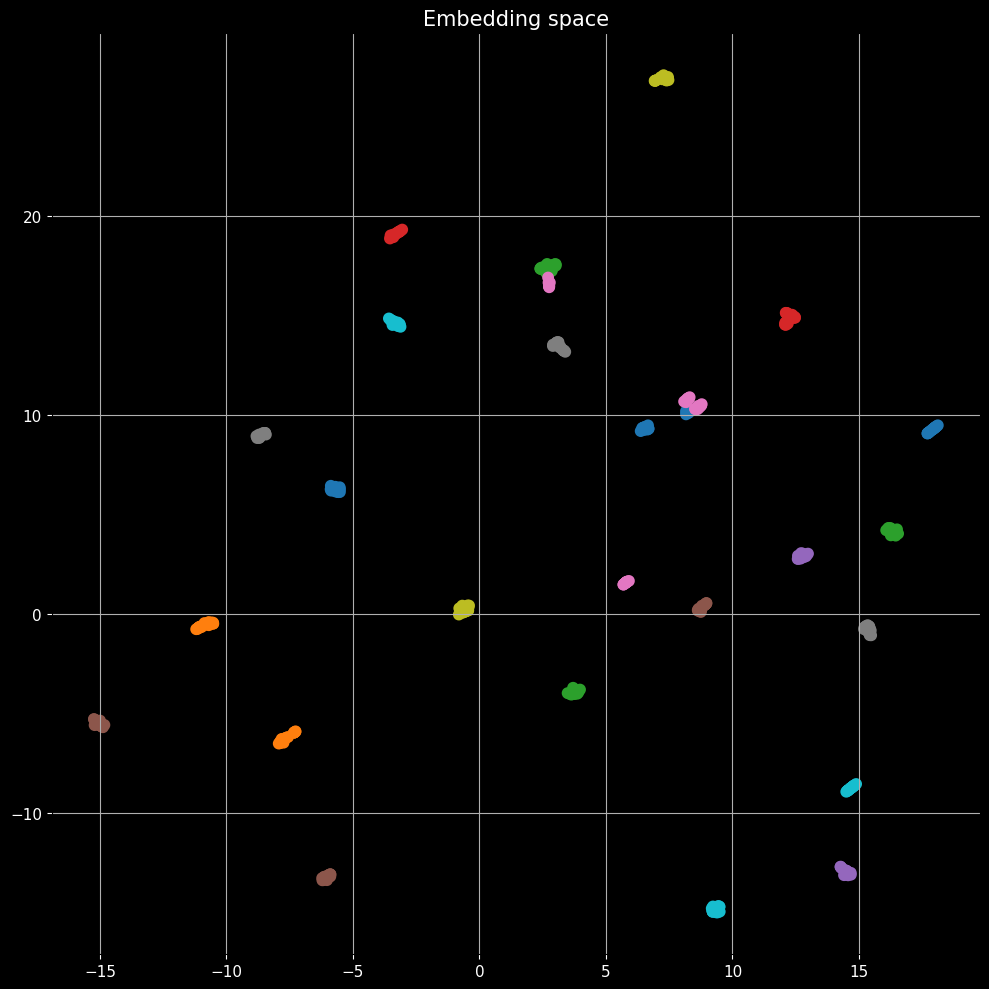

In [21]:
plot_embedding(embeddings, ids = samples['id'].values, with_legend = False)

## Distance matrix visualization

The projection well illustrates the presence of clusters. It is now useful to assess this by showing the distance between each pair of embeddings. This distance matrix can be computed via the `distance` method with `as_matrix = True`. 

Note that, for convenience, in the below cell, `- distance(...)` is shown in order to display the *similarity* matrix rather than the *distance* matrix. This allows to highlight clusters of similar samples, which is more convenient ;)

Thanks to the `samples.sort_values('id')` performed earlier, all embeddings from the same speaker are contiguous, and each speaker has 25 samples, meaning that every 25 lines/rows, it is a different speaker. This means that the 25 first rows/columns represent distance between the embeddings of the 1st speaker, 25 to 50 the 2nd speaker, etc. Therefore, we may expect that embeddings on the diagonal are grouped into clusters of 25 embeddings. This exactly represented on the below similarity matrix ! :)

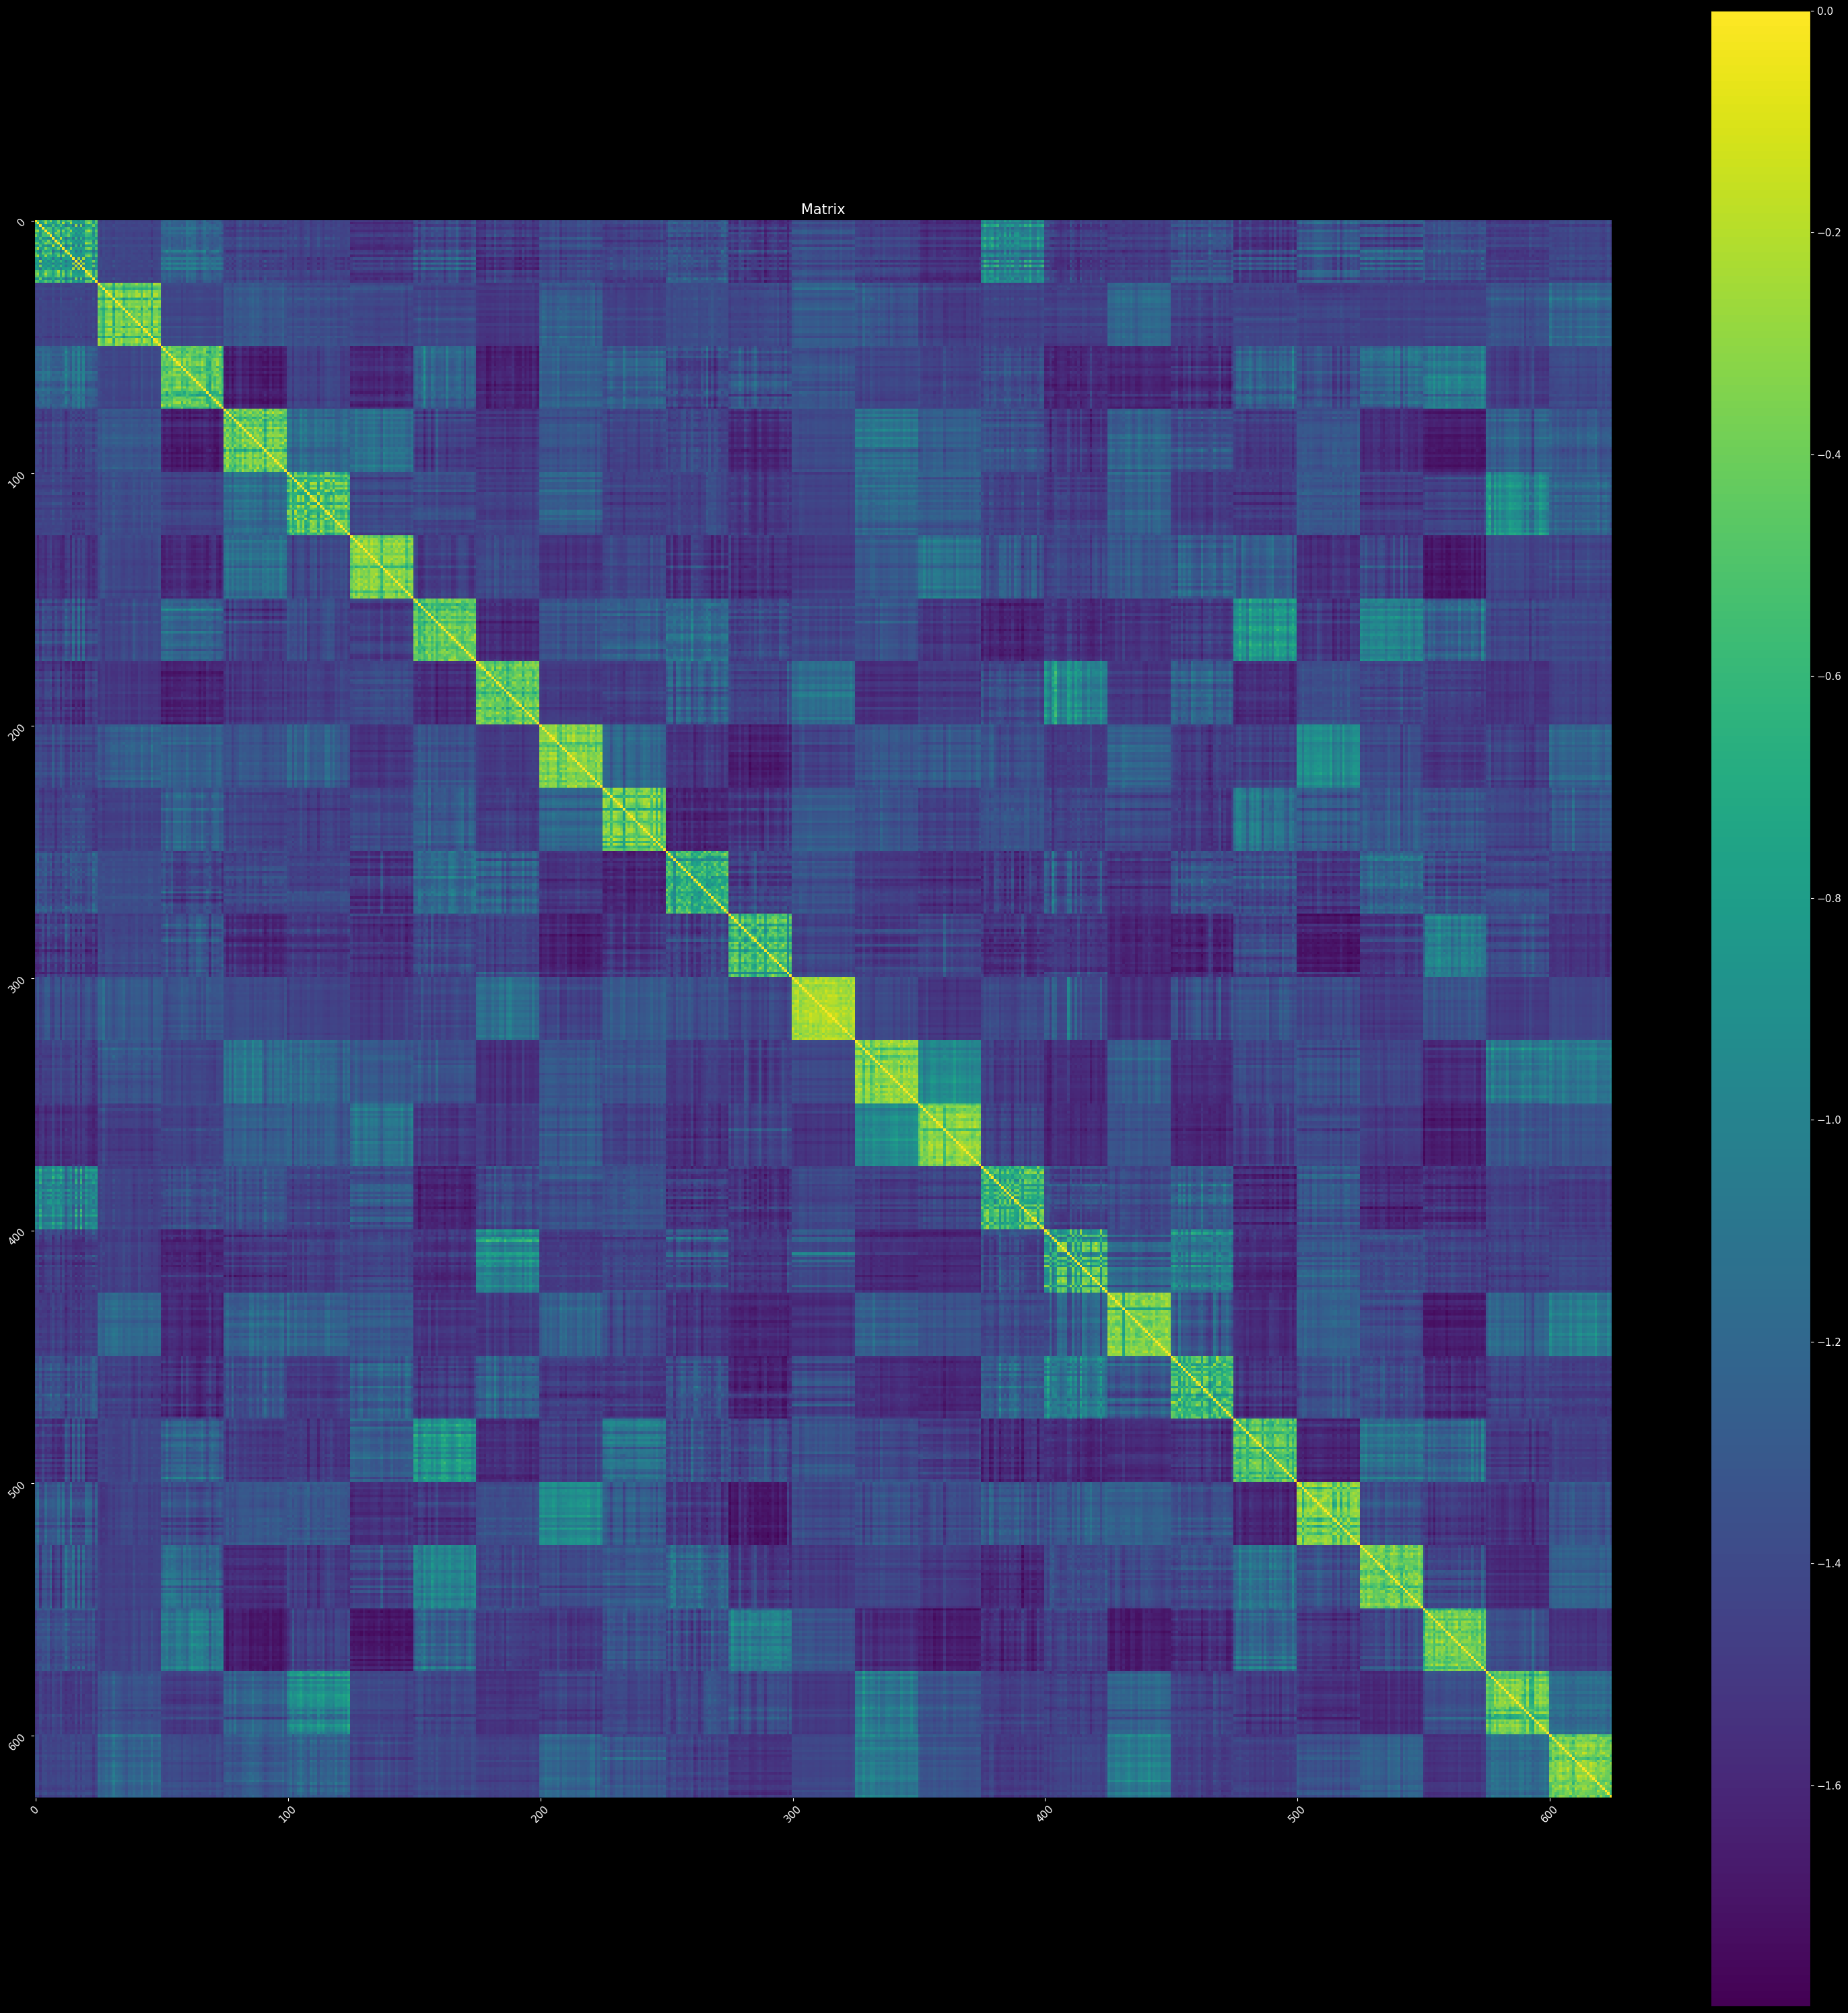

In [22]:
plot_matrix(- distance(embeddings, embeddings, model.distance_metric, as_matrix = True))

## Prediction on new samples

The methodology is based on the above observations : 
- The embeddings from the same speakers tend to have a lower distance compared to embeddings from different speakers.
- The 1st step is therefore to embed the audio samples for which we want to predict the speaker
- Then, the `K-Nearest Neighbor (KNN)` algorithm is used to get the majority label for each embeddings to predict, based on the reference embeddings for which we have the speaker id.
- Finally, the prediction can be compared to the expected ids from these *new* audios :)

In [7]:
new_embeddings = model.embed(new_samples)
print('Embeddings shape : {}'.format(new_embeddings.shape))#model.plot_embedding(sample_df(valid, n = 25, n_sample = 25))

Embeddings shape : (625, 256)


In [8]:
pred = knn(new_embeddings, embeddings, ids = samples['id'].values, distance_metric = model.distance_metric, k = 5)

In [9]:
import numpy as np

speakers = {spk : i for i, spk in enumerate(samples['id'].unique())}

pred_idx = np.array([speakers[p] for p in convert_to_str(pred)])
true_idx = np.array([speakers[t] for t in samples['id'].values])

print('Accuracy : {:.2f} %'.format(100 * np.mean(true_idx == pred_idx)))
print('Target : {}'.format(true_idx))
print('Pred   : {}'.format(pred_idx))

Accuracy : 99.36 %
Target : [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 1